In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np

## 1. Read Data

In [3]:
path = "https://raw.githubusercontent.com/frandiego/auxiliar/master/churn_train.csv"
df = pd.read_csv(path)

## 2. Split in X and y 
by the way (y is called `Churn`)

In [4]:
X,y = df.drop(['Churn'],axis=1),df['Churn']

## 3. Split in train and test (X_train, X_test, y_train, y_test)
#### arguments
```python
test_size=0.25, stratify=y, random_state=101
```

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                    test_size=0.25, 
                                                    stratify=y, 
                                                    random_state=101)

### 2.1. Clean column names  (to lowercase)

In [6]:
X_train.columns = list(map(lambda i:i.lower(), X_train.columns))

### 2.2. Remove those columns with non-info-columns (column with unique values or 1 value)

In [7]:
# columns with columns that have unique numbers or 1 unique value
columns_with_no_info = list(X_train.columns[X_train.nunique().isin([len(X_train),1])])

In [8]:
print(columns_with_no_info)

['customerid']


In [9]:
X_train = X_train.drop(columns_with_no_info, axis=1)

### 2.3. Create a variables name `categorical` with a list of those categoricals columns (for example those columns with less  than 25 unique categoricals)

In [10]:
categoricals = list(X_train.columns[X_train.nunique()<25])

### 2.4. Use this safe map encoder version to create a `map_encoder` and transform `X_train` (only the categorical columns)

In [11]:
map_encode = lambda i: dict(zip(sorted(set(i)),list(range(len(set(i))))))
map_encode_fit = lambda df, features : dict(zip(features,map(lambda i: map_encode(df[i]), features)))
map_encoder_transform = lambda df, map_encoder : pd.concat(map(lambda i: df[i[0]].map(i[1]), 
                                                               map_encoder.items()), axis=1)
map_onehot_encoder = lambda df,features: pd.concat(map(lambda i:pd.get_dummies(df[i],
                                                                      prefix=i,
                                                                      drop_first=True), 
                                                      features),axis=1)

In [12]:
map_encoder = map_encode_fit(X_train, categoricals)

### 2.5. Create a list name `numericals` with the names of those columns that are not categoricals

In [13]:
numericals = list(set(X_train.columns).difference(categoricals))

### 2.6. Concatenate the result of map encoded version of `X_train` and the numerical columns of `X_train`

In [14]:
X_train = pd.concat([X_train[numericals],map_encoder_transform(X_train, map_encoder)], axis=1)

### 2.7. Check that all data types are integer of floats

### 2.8. Create a dictionary like the following and name it `transfomer`
```python
transformer = {'numericals':[numerical columns], 
               'encoder' : [result of the map_encoder_fit applied to train]}
```

In [15]:
categoricals = list(X_train.columns[X_train.nunique()<25])

### 2.9. Create a function called `fit` that take a dataframe and return something like the `transfomer`, so wrap al the transformations (cleaning and transforming) already done. 

In [16]:
def fit(df):
    # clean columns
    df.columns = list(map(lambda i:i.lower(), df.columns))
    # no info cols
    no_info = list(df.columns[df.nunique().isin([len(df),1])])
    if no_info:
        df = df.drop(no_info, axis=1)
    # categoricals
    categoricals = list(df.select_dtypes('object').columns)
    # numericals
    numericals = list(set(df.columns).difference(categoricals))
    # map encoder
    map_encoder = map_encode_fit(df, categoricals)
    # create the transfomer
    transformer = {'numericals': numericals, 'encoder':map_encoder}
    return transformer


### 2.10. Create a function called `transfom` that take a dataframe and a `transfomer` and return the transfomed version of the datagrame

In [17]:
def transform(df, transformer, onehot=True):
    # to lower columns
    df.columns = list(map(lambda i:i.lower(), df.columns))
    # numericla and categoricals
    numericals = tranformer['numericals']
    categoricals = list(tranformer['encoder'].keys())
    # take numerical columsn
    df_numericals = df[numericals]
    # transform the dataframe
    df_categoricals = map_encoder_transform(df, tranformer['encoder'])
    # crete the onehot dataframe
    if onehot:
        df_categoricals = map_onehot_encoder(df_categoricals, categoricals)
    return pd.concat([df_numericals,df_categoricals], axis=1)


## 3. Transfom `train` and `transform`

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                    test_size=0.25, 
                                                    stratify=y, 
                                                    random_state=101)

In [19]:
tranformer = fit(X_train)
X_train    = transform(X_train, tranformer)
X_test     = transform(X_test, tranformer)

# 5. Model. In a Churn model we are going to try to catch all churners so the metric we are going to maximize is recalls for churners (ones)

## 5.1 Logistic Regression

AUC    :  0.719
Kappa  :  0.47
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.67      0.53      0.59       374

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.73      1409
weighted avg       0.80      0.81      0.80      1409



## 5.2 Suppor Vector Classifier

AUC    :  0.5
Kappa  :  0.0
              precision    recall  f1-score   support

           0       0.73      1.00      0.85      1035
           1       0.00      0.00      0.00       374

    accuracy                           0.73      1409
   macro avg       0.37      0.50      0.42      1409
weighted avg       0.54      0.73      0.62      1409



/Users/fran/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 5.3 KNN

AUC    :  0.666
Kappa  :  0.365
              precision    recall  f1-score   support

           0       0.81      0.90      0.85      1035
           1       0.61      0.43      0.51       374

    accuracy                           0.78      1409
   macro avg       0.71      0.67      0.68      1409
weighted avg       0.76      0.78      0.76      1409



## 5.4 Decision Tree Classifier

AUC    :  0.66
Kappa  :  0.318
              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1035
           1       0.50      0.50      0.50       374

    accuracy                           0.73      1409
   macro avg       0.66      0.66      0.66      1409
weighted avg       0.73      0.73      0.73      1409



## 5.5. Random Forest

AUC    :  0.69
Kappa  :  0.418
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1035
           1       0.65      0.47      0.55       374

    accuracy                           0.79      1409
   macro avg       0.74      0.69      0.71      1409
weighted avg       0.78      0.79      0.78      1409



## 6. Plot the ROC curve of the best one

/Users/fran/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


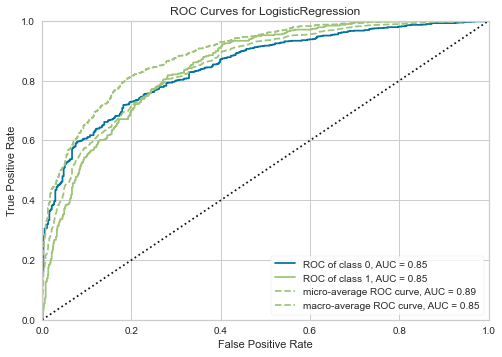